In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from keras.layers import Conv2D,MaxPool2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [50]:
train_datagen = ImageDataGenerator(rescale= 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator (rescale = 1./255)

training_set = train_datagen.flow_from_directory("Train",
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical') 

Validation_set = val_datagen.flow_from_directory("Validation",
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')
#test_set = test_datagen.flow_from_directory('Test', target_size= (224,224), class_mode= 'categorical')


Found 763 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [9]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(4, activation='softmax'))

In [10]:
cnn1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               50466944  
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 50,468,356
Trainable params: 50,468,356
Non-trainable params: 0
__________________________________________

In [11]:
#Using Learning rate schedule to modulate the changes of learning rate over time
#Constant learning rate is default, Momentum and Decay both are set to zero
#Here Using momentum to get the faster convergence, Between 0.5 and 0.9 is acceptable, Will experiment with different momentum
#Decay rate is basically learning_Rate / epochs
#Step decay schedule drops the learning rate by a factor every few epochs.


# Compile the model. I found that RMSprop with the default learning
# weight worked fine.


cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [12]:
CNN_Model=cnn1.fit_generator(
    training_set,
    steps_per_epoch=12,
    epochs=13,
    validation_data=Validation_set,
    validation_steps=3,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

Epoch 1/13
12/12 [==============================] - 115s 10s/step - loss: 33.7397 - accuracy: 0.2267 - val_loss: 4.7184 - val_accuracy: 0.2663
Epoch 2/13
12/12 [==============================] - 101s 8s/step - loss: 2.5467 - accuracy: 0.3132 - val_loss: 1.3014 - val_accuracy: 0.3011
Epoch 3/13
12/12 [==============================] - 85s 7s/step - loss: 1.2564 - accuracy: 0.4181 - val_loss: 1.2961 - val_accuracy: 0.3424
Epoch 4/13
12/12 [==============================] - 99s 8s/step - loss: 1.1825 - accuracy: 0.4456 - val_loss: 1.2592 - val_accuracy: 0.3665
Epoch 5/13
12/12 [==============================] - 84s 7s/step - loss: 1.1239 - accuracy: 0.5046 - val_loss: 1.1644 - val_accuracy: 0.4429
Epoch 6/13
12/12 [==============================] - 115s 10s/step - loss: 1.0601 - accuracy: 0.5164 - val_loss: 1.1301 - val_accuracy: 0.4972
Epoch 7/13
12/12 [==============================] - 98s 8s/step - loss: 0.9901 - accuracy: 0.5478 - val_loss: 1.2184 - val_accuracy: 0.3967
Epoch 8/13
12/

# Transfer Learning with VGG16

In [6]:
prior = keras.applications.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(224, 224, 3)
)
model = Sequential()
model.add(prior)
model.add(Dropout(0.25, name='FirstDropout_Regularization'))
model.add(Flatten())
model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.25, name='Dropout_Regularization'))
model.add(Dense(4, activation='softmax', name='Output'))

In [7]:
# Freeze the VGG16 model, e.g. do not train any of its weights.
# We will just use it as-is.
for cnn_block_layer in model.layers[0].layers:
    cnn_block_layer.trainable = False
model.layers[0].trainable = False

In [8]:
# Compile the model. I found that RMSprop with the default learning
# weight worked fine.
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
Transfer_Learning=model.fit_generator(
    training_set,
    steps_per_epoch=5,
    epochs=10,
    validation_data=Validation_set,
    validation_steps=2,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

Epoch 1/10
5/5 [==============================] - 189s 38s/step - loss: 3.0380 - accuracy: 0.4857 - val_loss: 1.4888 - val_accuracy: 0.6458
Epoch 2/10
5/5 [==============================] - 236s 47s/step - loss: 2.3154 - accuracy: 0.5219 - val_loss: 2.3282 - val_accuracy: 0.3333
Epoch 3/10
5/5 [==============================] - 211s 42s/step - loss: 1.4778 - accuracy: 0.6031 - val_loss: 0.7764 - val_accuracy: 0.5917
Epoch 4/10
5/5 [==============================] - 166s 33s/step - loss: 1.5106 - accuracy: 0.5968 - val_loss: 0.8241 - val_accuracy: 0.5708
Epoch 5/10
5/5 [==============================] - 186s 37s/step - loss: 0.9468 - accuracy: 0.6159 - val_loss: 1.6711 - val_accuracy: 0.5833
Epoch 6/10
5/5 [==============================] - 177s 35s/step - loss: 1.2913 - accuracy: 0.6062 - val_loss: 0.6780 - val_accuracy: 0.6750
Epoch 7/10
5/5 [==============================] - 166s 33s/step - loss: 0.7584 - accuracy: 0.6781 - val_loss: 0.6376 - val_accuracy: 0.7333
Epoch 8/10
5/5 [====

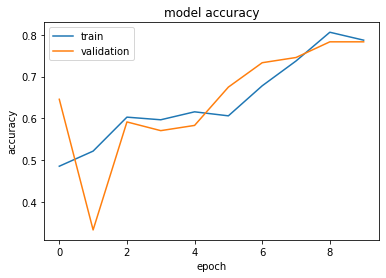

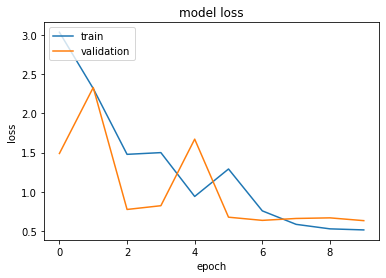

In [11]:
#  "Accuracy"
plt.plot(Transfer_Learning.history['accuracy'])
plt.plot(Transfer_Learning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(Transfer_Learning.history['loss'])
plt.plot(Transfer_Learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [40]:
import tensorflow as tf

from keras.models import load_model

model.save('Mango9.03.h5')

In [21]:
#predictions = model.predict_generator(generator= test_set, steps=1, verbose=0)